In [1]:
from uproot_methods import TLorentzVectorArray as lv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.stats import chisquare

In [2]:
k  = pd.read_parquet('/home/taymaz/Documents/Flows/Data/data.kinematics.MDR_VEC.2018.parquet', engine='pyarrow', columns=['ntag', 'kinematic_region', 'pass_vbf_sel', 'm_h1', 'm_h2', 'log_pT_h1', 'log_pT_h2', 'eta_h1', 'eta_h2', 'log_dphi_hh', 'm_hh', 'absCosThetaStar'])

mask_2b     = k['ntag'] == 2
mask_4b     = k['ntag'] >= 4
mask_CR     = k['kinematic_region'] == 2
mask_VR     = k['kinematic_region'] == 1
mask_SR     = k['kinematic_region'] == 0 
mask_CRVR   = (k['kinematic_region'] == 1) | (k['kinematic_region'] == 2)
mask_vbf    = k['pass_vbf_sel'] == False

k_hh = k.loc[(mask_4b & mask_CRVR & mask_vbf), ( 'm_hh','absCosThetaStar','m_h1','m_h2')]

del k

In [3]:
bootstraps = 25
k_bootstraps = []
for n in range(1, bootstraps+1, 1):
    k_n = pd.read_hdf('/home/taymaz/Documents/Flows/2018/Trainings/k_flow/4b-MDR-fix-bug/eval_bootstrap_%d.h5' % n)
    k_bootstraps.append(k_n)
    #k_bootstraps.append(np.log(k_n))

    
def mean_histogram(k_bootstraps, column, bins, min_hist_range, max_hist_range, density=True):
    
    hist_bootstraps = []
    for k in k_bootstraps:
        hist, _ = np.histogram(k[column], bins, range=[min_hist_range, max_hist_range], density=density)
        hist_bootstraps.append(hist)
    
    hist_mean = sum(hist_bootstraps)/float(len(hist_bootstraps))
    hist_std = np.std(hist_bootstraps, axis=0)
    
    return hist_mean, hist_std


def chi_square_ndf(k, k_bootstraps, column, bins, min_hist_range, max_hist_range, density=False):
    
    obsfreq, _ = mean_histogram(k_bootstraps, column, bins, min_hist_range, max_hist_range, density)
    expfreq, _ = np.histogram(k[column], bins, range=[min_hist_range, max_hist_range], density=density)
    
    chi2ndf = chisquare(obsfreq[expfreq!=0], expfreq[expfreq!=0], bins-1)[0]/(bins-1)
    
    return chi2ndf ,sum((obsfreq[expfreq!=0]-expfreq[expfreq!=0])**2 / expfreq[expfreq!=0])/79, sum(obsfreq), sum(expfreq)


In [4]:
min_mhh, max_mhh = 200, 1000
min_cos, max_cos = 0, 1
bins = 80
density = True

# chi2smhh = []
# for i in range(100):
#     chi2 = chi_square_ndf(k_hh.sample(len(k_bootstraps[0])), k_bootstraps, 'm_hh', bins, min_mhh, max_mhh)
#     chi2smhh.append(chi2[0])
# chi2_m_hh = np.mean(chi2smhh)
# print(chi2_m_hh)

# chi2scos = []
# for i in range(100):
#     chi2 = chi_square_ndf(k_hh.sample(len(k_bootstraps[0])), k_bootstraps, 'absCosThetaStar', bins, min_cos, max_cos)
#     chi2scos.append(chi2[0])
# chi2_cos = np.mean(chi2scos)
# print(chi2_cos)

Text(0.5, 0, '$\\mid\\cos{\\theta^*}\\mid$')

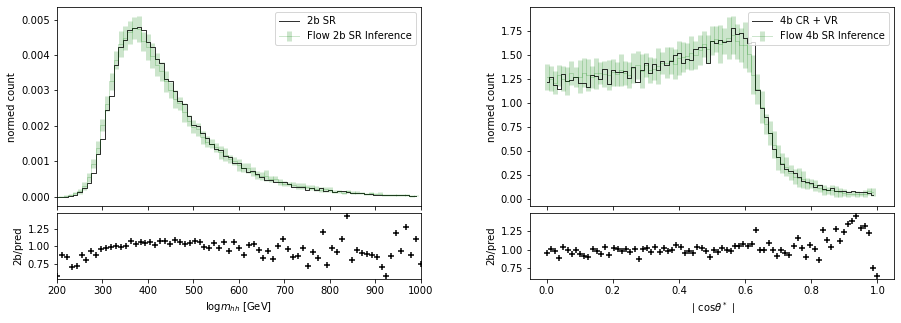

In [5]:
m_hh, x_mhh = np.histogram(k_hh['m_hh'], bins, range=[min_mhh, max_mhh], density=density)
cos, x_cos = np.histogram(k_hh['absCosThetaStar'], bins, range=[min_cos, max_cos], density=density)
m_hh_flow, m_hh_flow_std = mean_histogram(k_bootstraps, 'm_hh', bins, min_mhh, max_mhh, density)
cos_flow, cos_flow_std = mean_histogram(k_bootstraps, 'absCosThetaStar', bins, min_cos, max_cos, density)


fig = plt.figure(figsize=(15,5))
spec = gridspec.GridSpec(ncols=2, nrows=2, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

ax00 = fig.add_subplot(spec[0,0])
ax01 = fig.add_subplot(spec[0,1])
ax10 = fig.add_subplot(spec[1,0], sharex=ax00)
ax11 = fig.add_subplot(spec[1,1], sharex=ax01)

ax00.step(x_mhh[0:bins], m_hh, label='2b SR', color='k', alpha=0.8, linewidth=1, where='mid')
ax00.errorbar(x_mhh[0:bins], m_hh_flow, yerr=m_hh_flow_std, label='Flow 2b SR Inference', color='green', alpha=0.2, linewidth=1, ds='steps-mid', ecolor='green', elinewidth=5,)
ax00.legend(loc='upper right')
#ax00.text(700, 0.003, f"$\chi^2$/ndf = {float(f'{chi2_m_hh:.3g}'):g}\n")
ax00.set_xlim([min_mhh, max_mhh])
plt.setp(ax00.get_xticklabels(), visible=False)
ax00.set_ylabel('normed count')


ax01.step(x_cos[0:bins], cos, label='4b CR + VR', color='k', alpha=0.8, linewidth=1, where='mid')
ax01.errorbar(x_cos[0:bins], cos_flow, yerr=cos_flow_std, label='Flow 4b SR Inference', color='green', alpha=0.2, linewidth=1, ds='steps-mid', ecolor='green', elinewidth=5,)
ax01.legend(loc='upper right')
#ax01.text(0.7, 1.25, f"$\chi^2$/ndf = {float(f'{chi2_cos:.3g}'):g}\n")
#ax01.set_ylim([0, 2])
plt.setp(ax01.get_xticklabels(), visible=False)
ax01.set_ylabel('normed count')

ax10.scatter(np.linspace(min_mhh, max_mhh,len(m_hh[4:-1]/m_hh_flow[4:-1])), m_hh[4:-1]/m_hh_flow[4:-1], color='k', marker='+', linewidths=0.5)
ax10.set_ylabel('2b/pred')
ax10.set_xlabel(r'log$m_{hh}$ [GeV]')

ax11.scatter(np.linspace(min_cos, max_cos, len(cos/cos_flow)), cos/cos_flow, color='k', marker='+', linewidths=0.5)
ax11.set_ylabel('2b/pred')
ax11.set_xlabel(r'$\mid\cos{\theta^*}\mid$')